# Val Strategy

> A good validation strategy is key to winning a competition
>
> — @CPMP

The val strategy should be trusted in and utilized for all feature engineering tasks and for hyper parameter tuning.

Generally, the best val strategy will somehow mimic the train-test (submission) spli, especially in cases when the public portion of the LB sorted orderly. In these cases, the Public LB score can even be used as another 'fold'.

# What we Know

PublicLB is the first **20%** of the test set _by number of samples_

- This corresponds to the frist 118108 of 590540 samples
- If we assume 2017-11 start date, 2018-07-10
- If we assume 2018-12 start date, 2018-08-09

We also know that there gap between the train and test set is **31 days**:
    
- If we assume 2017-11 start date, 2018-05-02 through 2018-05-31
- If we assume 2018-11 start date, 2018-06-01 through 2018-06-31

If **2017-11-01** is the first day:
- Train 2017-11-01 through 2018-05-01
- Test  2018-06-01 through 2018-11-30
- **Con** Train ends on 2018-05-01 instead of 2018-04-31, which is weird
- **Con** Train/Test gap: 2018-05-02 through 2018-05-31
- **Pro** 2018-11-30 is 30 days long so there,s a match
- **Pro** Mitigates some of the issues surrounding OS releases occurring before the transaction date

If **2017-12-01** is the first day:
- Train 2017-12-01 through 2018-05-31
- Test  2018-07-01 through 2018-12-30
- **Pro** 2018-05-31 is 31 days long
- **Con** Some OS's used were released after the purported transaction date
- **Con** Test set ends on 2018-12-30 instead of 2018-12-31
- **Pro** Christmas alignment
- **Pro** Train/Test gap: 2018-06-01 through 2018-06-31

Start date aside, the gap between train and val should mimic the gap between train + test (submission), that is 31 full days worth of seconds.

For the validation set size, we can either build that using the number of samples 118108 = 20% of test set size. Or alternatively we can build it using a fixed time of roughly six-weeks. I perfer the time value rather than the sample size value because the density of samples within the train set varies A LOT, which would mean sometimes our train set might be jsut 3 weeks long and other times it might be 5 weeks. Not a consistent want to test things out.

In summary, my recommendation is split by time. So _minimally_, we need 73 days (31 day gap plus 6 x 7 day validation) worth of data to be held out forvalidation purposes. As for the amount of training data we use, it can be whatever size we want. The bigger the size, the fewer splits we can make.

In [55]:
START_DATE = '2017-12-01'

In [85]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

traintr = pd.read_csv('input/train_transaction.csv.zip')
trainid = pd.read_csv('input/train_identity.csv.zip')
testtr  = pd.read_csv('input/test_transaction.csv.zip')
testid  = pd.read_csv('input/test_identity.csv.zip')

In [94]:
mindt = traintr.TransactionDT.min()
startdate         = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')

traintr['tdt']    = traintr.TransactionDT - mindt
traintr['tdt']    = traintr['tdt'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
traintr['tdate']  = traintr.tdt.dt.date

testtr['tdt']    = testtr.TransactionDT - mindt
testtr['tdt']    = testtr['tdt'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
testtr['tdate']  = testtr.tdt.dt.date

In [100]:
def feature_val_folds(train_days=6*7, fold_gap_days=7, sub_fold=False, plot=False):
    # Creates folds for use in testing feature performance and variance ONLY
    # Do NOT use this setup for final submission!
    # If you want to submit against LB using LB as a final fold, specify sub_fold=True
    
    train = []
    val = []
    
    hrs_day = 24*60*60
    gap_size = 31*hrs_day  # 31 days
    val_size = 6*7*hrs_day # 6 weeks
    train_size = train_days*hrs_day
    
    useable = traintr.TransactionDT.iloc[-1] - gap_size - val_size - train_size
    
    if sub_fold:
        # If we want to use LB as a final 'fold', e.g. for probing, then train
        # on the data leading up to the LB. This is only for probing and creating
        # another data point and NOT for final submissions!
        a = traintr[traintr.TransactionDT > traintr.TransactionDT.max() - train_size]
        return
    
    for fold_start in range(traintr.TransactionDT.iloc[0], useable, fold_gap_days*hrs_day):
        fold_end = fold_start+train_days*hrs_day
        a = traintr[traintr.TransactionDT.between(fold_start, fold_end)]
        b = traintr[traintr.TransactionDT.between(fold_end + gap_size, fold_end + gap_size + val_size)]
        print('Train:', a.tdate.iloc[0], a.tdate.iloc[-1], '  Test:', b.tdate.iloc[0], b.tdate.iloc[-1])
        if plot:
            plt.figure(figsize=(8,6))
            plt.scatter(traintr.TransactionDT, traintr.D1, s=1, alpha=0.1)
            plt.axvline(a.TransactionDT.iloc[0], linewidth=1, linestyle='--', c='green')
            plt.axvline(a.TransactionDT.iloc[-1], linewidth=1, linestyle='--', c='green')
            plt.axvline(b.TransactionDT.iloc[0], linewidth=1, linestyle='--', c='red')
            plt.axvline(b.TransactionDT.iloc[-1], linewidth=1, linestyle='--', c='red')
            plt.show()

In [101]:
feature_val_folds()

Train: 2017-12-01 2018-01-11   Test: 2018-02-12 2018-03-25
Train: 2017-12-08 2018-01-18   Test: 2018-02-19 2018-04-01
Train: 2017-12-15 2018-01-25   Test: 2018-02-26 2018-04-08
Train: 2017-12-22 2018-02-01   Test: 2018-03-05 2018-04-15
Train: 2017-12-29 2018-02-08   Test: 2018-03-12 2018-04-22
Train: 2018-01-05 2018-02-15   Test: 2018-03-19 2018-04-29
Train: 2018-01-12 2018-02-22   Test: 2018-03-26 2018-05-06
Train: 2018-01-19 2018-03-01   Test: 2018-04-02 2018-05-13
Train: 2018-01-26 2018-03-08   Test: 2018-04-09 2018-05-20
Train: 2018-02-02 2018-03-15   Test: 2018-04-16 2018-05-27


Above is a simple example of usage. Note how we don't train at all on the last part of the data (because given the nature of our validateion scheme, we have no data to validate against). What's happening here might be hard to see, so let's visualize it using `D1` as a dummy variable:

Train: 2017-12-01 2018-01-11   Test: 2018-02-12 2018-03-25


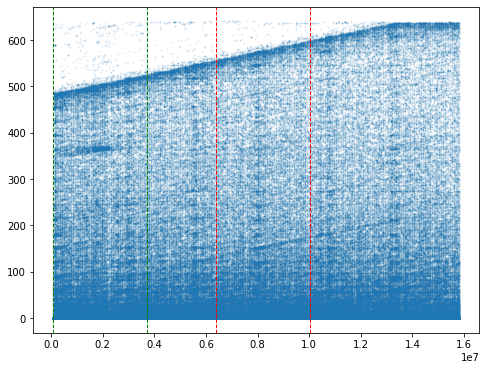

Train: 2017-12-08 2018-01-18   Test: 2018-02-19 2018-04-01


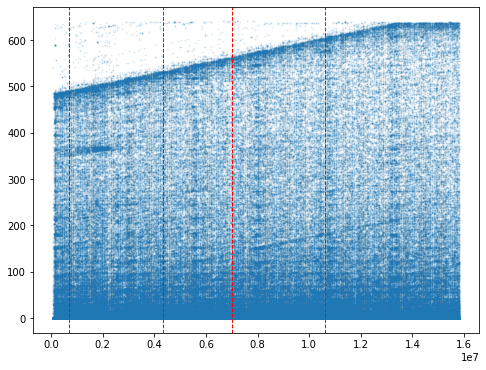

Train: 2017-12-15 2018-01-25   Test: 2018-02-26 2018-04-08


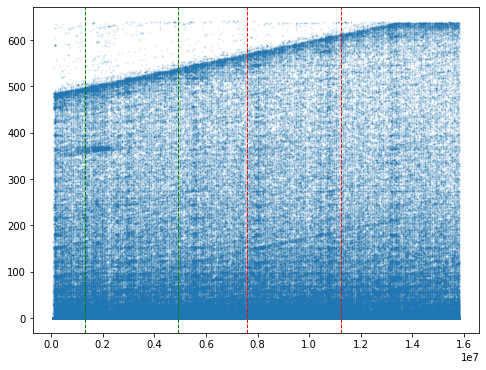

Train: 2017-12-22 2018-02-01   Test: 2018-03-05 2018-04-15


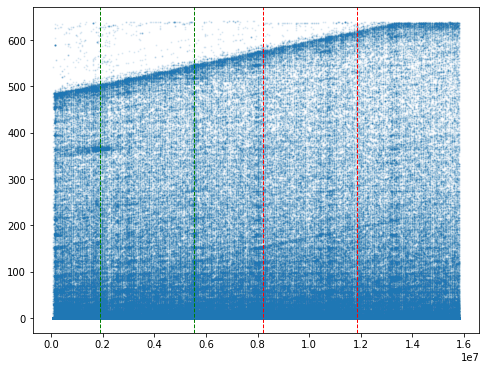

Train: 2017-12-29 2018-02-08   Test: 2018-03-12 2018-04-22


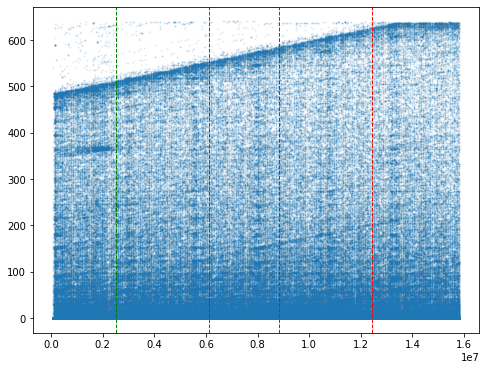

Train: 2018-01-05 2018-02-15   Test: 2018-03-19 2018-04-29


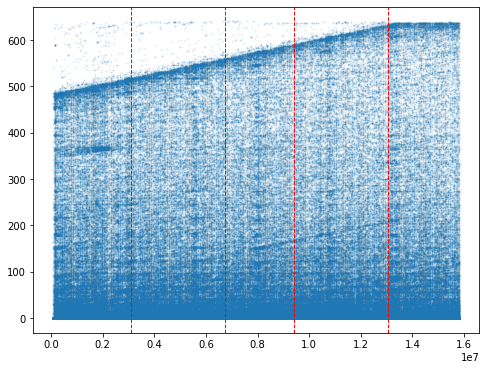

Train: 2018-01-12 2018-02-22   Test: 2018-03-26 2018-05-06


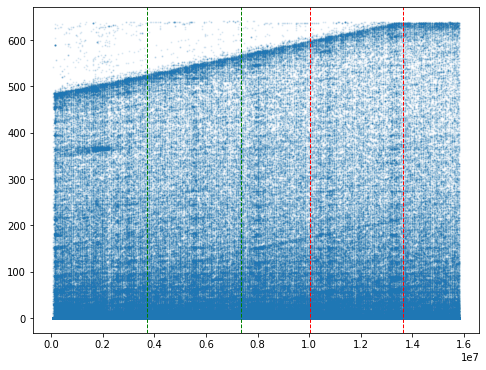

Train: 2018-01-19 2018-03-01   Test: 2018-04-02 2018-05-13


In [ ]:
feature_val_folds(plot=True)

Above I decided to make train (the green region) the same size as val (the red region). We can further increase the size of train to whatever we want... it's just that the larger it is, the less folds we can theoretically create.

Every fold is offset by 1week in the above example. We can increase or reduce this, it doesn't really matter. If you have enough CPU, I'd even take it down to just 1 day, that way you have many folds. Don't worry about overfitting or whatever, since we're only using this technique for _feature evaluation_ anyway, by having more folds and examining the resulting RoC AUC for features (model) as we slide the time window, we can observe which models+features are 'stable' as a function of time VERSUS which features wiggle too much and therefore might not be reliable in the test set.

Train: 2017-12-01 2018-02-08   Test: 2018-03-12 2018-04-22


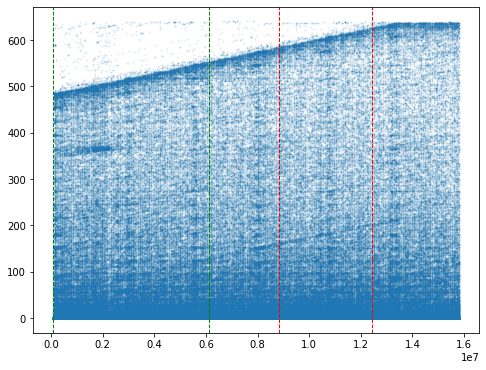

Train: 2017-12-08 2018-02-15   Test: 2018-03-19 2018-04-29


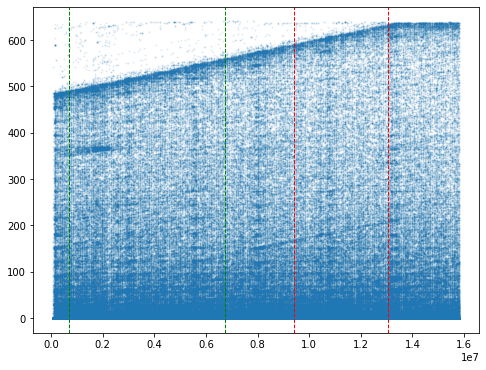

Train: 2017-12-15 2018-02-22   Test: 2018-03-26 2018-05-06


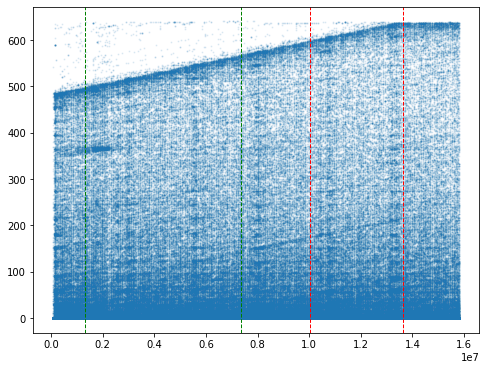

Train: 2017-12-22 2018-03-01   Test: 2018-04-02 2018-05-13


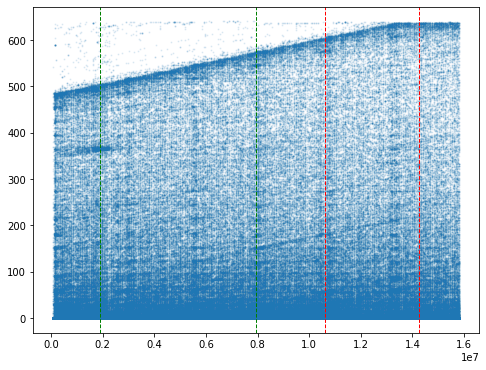

Train: 2017-12-29 2018-03-08   Test: 2018-04-09 2018-05-20


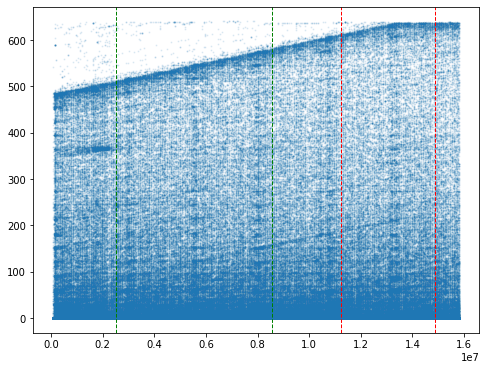

Train: 2018-01-05 2018-03-15   Test: 2018-04-16 2018-05-27


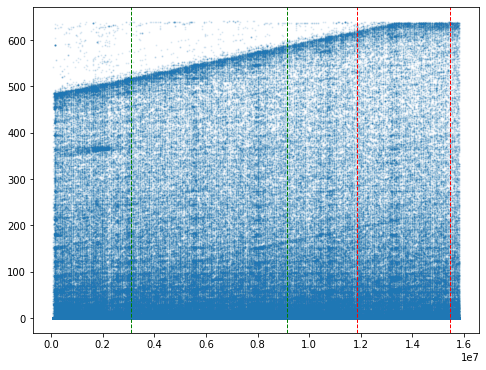

In [103]:
feature_val_folds(train_days=10*7, plot=True)

In [ ]:
# TODO: Plot train+test + subfold

# Production Version

In [117]:
def feature_val_folds(train_days=6*7, fold_gap_days=7, sub_fold=False):
    # Creates folds for use in testing feature performance and variance ONLY
    # Do NOT use this setup for final submission!
    # If you want to submit against LB using LB as a final fold, specify sub_fold=True
    
    folds = []
    
    hrs_day = 24*60*60
    gap_size = 31*hrs_day  # 31 days
    val_size = 6*7*hrs_day # 6 weeks
    train_size = train_days*hrs_day
    
    useable = traintr.TransactionDT.iloc[-1] - gap_size - val_size - train_size
    
    if sub_fold:
        # If we want to use LB as a final 'fold', e.g. for probing, then train
        # on the data leading up to the LB. This is only for probing and creating
        # another data point and NOT for final submissions!
        trn = traintr[traintr.TransactionDT > traintr.TransactionDT.max() - train_size]
        return trn.index.values # No val set.
    
    for fold_start in range(traintr.TransactionDT.iloc[0], useable, fold_gap_days*hrs_day):
        fold_end = fold_start+train_days*hrs_day
        trn = traintr[traintr.TransactionDT.between(fold_start, fold_end)]
        val = traintr[traintr.TransactionDT.between(fold_end + gap_size, fold_end + gap_size + val_size)]
        
        folds.append([trn.index.values, val.index.values])
        
    return folds

# How to use this

## Feature Eval:

Ideally, we use this to test existing and newly engineered features or models. A 'good' model would be one that doesn't vary that much (relatively) fold to fold and even on LB.

Whenever you make a submission, please save your submission .csv file, along with an immutable, static copy of the notebook that generated the submission.

In [106]:
folds = feature_val_folds(train_days=6*7, fold_gap_days=7)
subindices = feature_val_folds(train_days=6*7, fold_gap_days=7, sub_fold=True)

In [ ]:
# Features to train on here...
features = []

In [108]:
fld = []
auc = []
acc = []
rec = []
pre = []
f1s = []

for fold_, (trn_idx, val_idx) in enumerate(folds):
    trn = traintr[traintr.index.isin(trn_idx)]
    val = traintr[traintr.index.isin(val_idx)]
    
    # TODO: Modeling here
    # ...
    # trn[features], val[features]
    # trn.isFraud, val.isFraud
    
    # TODO: Validation here
    # ...
    y_true = val.isFraud
    y_pred = ...
    
    
    fld.append(fold_)
    acc.append(accuracy_score(y_true, y_pred.round()))
    rec.append(recall_score(y_true, y_pred.round()))
    pre.append(precision_score(y_true, y_pred.round()))
    f1s.append(f1_score(y_true, y_pred.round()))
    auc.append(clf.best_score['valid_1']['auc']) # roc_auc_score(y_true, y_pred)
    
local_val_results = pd.DataFrame({
    'fold': fld,
    'auc': auc,
    'accuracy': acc,
    'recall': rec,
    'precision': pre,
    'f1s': f1s
})
notes = str(datetime.datetime.now())[:16].replace(' ', '_').replace(':','').replace('-','')
local_val_results.to_csv('{}_local_val.csv'.format(notes), index=False)

In [ ]:
plt.scatter(np.arange(local_val_results.shape[0], local_val_results.auc))
plt.show()

And then...

In [115]:
trn = traintr[traintr.index.isin(subindices)][features]

# We can't build accuracy, precision, recall, etc. for PublicLB; but we can test auc:
# This just gives us another fold...

## Final Submission

For submission, once we've selected the best model / features we wish to keep, train on the FULL dataset.

We can select best number of boosting rounds based on LB validation.

In [ ]:
# ...